In [1]:
import matplotlib as mpl
from Datasets import * 

import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=3, linewidth=120)
from LiteModels import DeepLite
from Datasets import *

from MMD.mmd import MMD_3_Sample_Test
import h5py as h5
from tqdm import trange
from scipy.misc import imresize
import seaborn as sns
import pandas as pd

from nuts import nuts
from nuts.emcee_nuts import NUTSSampler
from maf import experiments as ex

%matplotlib inline

Using cuDNN version 6021 on context None
Mapped name None to device cuda: GeForce GTX 1080 Ti (0000:84:00.0)


## Load data

In [2]:
seed = 1
#dname = "funnel"
#p = load_data("funnel",D=2,  N=5000, valid_thresh=0.0, seed=seed, itanh=False, whiten=True)
#p = load_data("spiral",D=2,  N=5000, data_args={"sigma":0.2, "eps":1.5}, valid_thresh=0.0, seed=seed, itanh=False, whiten=True)
#p = load_data("ring",D=2, data_args={"nring":1, "sigma":0.2}, N=5000, valid_thresh=0.0, seed=seed, itanh=False, whiten=True)
p = load_data("cosine",D=2, N=5000, valid_thresh=0.0, seed=seed, itanh=False, whiten=True)

data = np.random.rand(5000,2) * 6-3
p = ArrayDataset(data, "array", whiten=False, ntest=1000)
maf_data_obj = ex.load_data("array", data_array=data)

D = p.D
    
plot_size=8
ngrid = 100

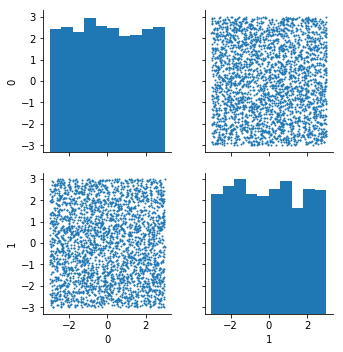

In [3]:
# visualise data

df = pd.DataFrame(p.sample(3000))
sns.pairplot(df,plot_kws=dict(s=4, alpha=1.0, linewidth=0))

In [ ]:
ps = []
logliks = []
model_names = []
ps.append(load_data("funnel",D=2,  N=5000, valid_thresh=0.0, seed=seed, itanh=False, whiten=True))
ps.append(load_data("spiral",D=2,  N=5000, data_args={"sigma":0.2, "eps":1.5}, valid_thresh=0.0, seed=seed, itanh=False, whiten=True))
ps.append(load_data("ring",D=2, data_args={"nring":1, "sigma":0.2}, N=5000, valid_thresh=0.0, seed=seed, itanh=False, whiten=True))
ps.append(load_data("cosine",D=2, N=5000, valid_thresh=0.0, seed=seed, itanh=False, whiten=True))

for p in ps:

    dl_model = DeepLite(p, npoint=200, nlayer=3, nneuron=20, init_log_lam=-3, points_std=0.0, keep_prob=1.0, init_weight_std=1.0, noise_std=0.0,
                        points_type="fixed", log_lam_weights=-6, step_size=1e-3, mixture_kernel=False, init_log_sigma=np.linspace(0,1,1), base=True,
                        niter=10000, ntrain=100, nvalid=200, patience=100, seed=seed,gpu_count=1)
    res = dl_model.fit(niter=10000, ntrain=100, nvalid=100,ntest=500, nbatch=1, patience=100)
    
    dl_model.set_test(True, 0) 
    dl_model.fit_alpha(5000)
        
    dl_model.logZ = None
    dl_model.estimate_normaliser(n=2*10**6, batch_size=10**5, std=p.test_data.std()*1.0)
    test_loglik = dl_model.estimate_data_lik(p.test_data, batch_size=p.test_data.shape[0])
    dl_model_loglik = test_loglik.mean()
    logliks.append(dl_model_loglik)
    print dl_model_loglik
    
    model_names.append(dl_model.default_file_name())
    
#dl_model.load()

In [151]:
logliks

[-3.5497308314897253,
 -3.4261680583749841,
 -3.3447567548118551,
 -3.6767081756130184]

In [141]:
logliks

[-3.5640132469957209,
 -3.2885057212639093,
 -3.3068480488543508,
 -3.7404088685572905]

# Training the model
If want to retrain, set `gpu_count=1` if you have a gpu

In [ ]:
dl_model = DeepLite(p, npoint=200, nlayer=3, nneuron=10, init_log_lam=-3, points_std=0.0, keep_prob=1.0, init_weight_std=1.0, noise_std=0.05,
                    points_type="fixed", log_lam_weights=-6, step_size=1e-3, mixture_kernel=False, init_log_sigma=np.linspace(0,1,1), base=True,
                    niter=1000, ntrain=200, nvalid=200, patience=100, seed=seed,gpu_count=1)
res = dl_model.fit(niter=10000, ntrain=200, nvalid=200,ntest=500, nbatch=1, patience=100)

trainining kernel:   6%|  | 576/10001 [01:32<20:38,  7.61it/s[{'test': '-1.710', 'loss': '-1.564'}]]

# visualize some variables in the model

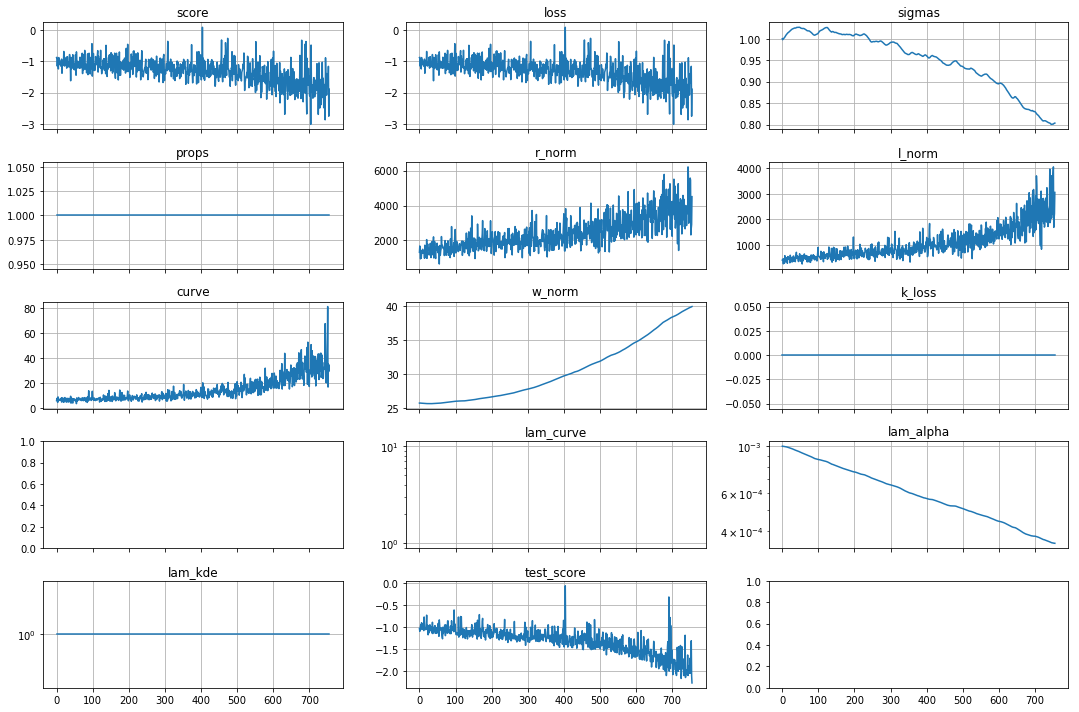

In [19]:
fig, axes = plt.subplots(5,3,figsize=(15,10), sharex=True)

axes = axes.flatten()
res = dl_model.state_hist

for ki, k in  enumerate(res):
    if k == "lam_norm":
        continue
    ax = axes[ki]
    ax.plot(res[k])
    ax.set_title(k)
    if "lam" in k: 
        ax.set_yscale("log")
    ax.grid("on")
        
        
fig.tight_layout()

In [20]:
# final fit of alphas. Better do it on cpu so have to redefine the model (set True) and tell it gpu_count = 0
dl_model.set_test(True, 0) 
dl_model.fit_alpha(5000)

INFO:tensorflow:Restoring parameters from ckpts/a_D02_l3_nd10_np200_nt200_nv200_ptf_ss10_ni1000_n00_k10_m0_b1_p100_nk1_s01.ckpt


In [21]:
# evaluate log likelihood, repeat to see whether reliable
for i in range(2):
    dl_model.logZ = None
    dl_model.estimate_normaliser(n=2*10**6, batch_size=10**5, std=p.test_data.std()*1.0)
    test_loglik = dl_model.estimate_data_lik(p.test_data, batch_size=p.test_data.shape[0])
    print test_loglik.mean()
dl_model_loglik = test_loglik.mean()

-3.65302749836
-3.65329722965


# Visualise density of two dimensions conditioned on others dimensions being zeros

In [22]:
def get_grid(r, i, j, cond):


    grid = np.meshgrid(r,r)

    grid = np.stack(grid,2)
    grid = grid.reshape(-1,2)
    
    num_point = len(grid)
    grid_cond = np.tile(cond[None,:], [num_point, 1])
    
    grid_cond[:,i] = grid[:,0]
    grid_cond[:,j] = grid[:,1]
    return grid_cond

(-8.0, 8.0)

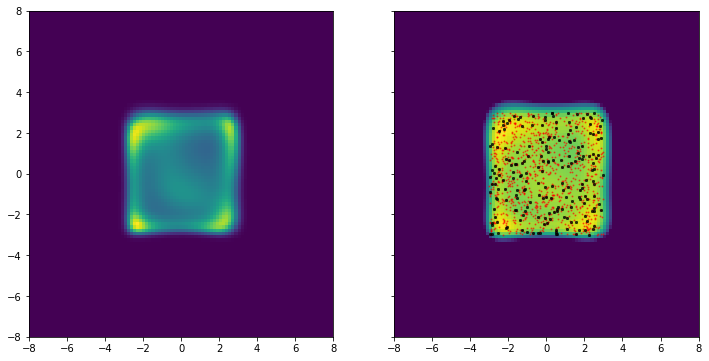

In [23]:
idx_i, idx_j = 0,1

ngrid = 100
eval_grid = np.linspace(-8,8,ngrid)

cond_values = np.zeros(p.D)
epsilon = 1.5

eval_points = get_grid(eval_grid, idx_i, idx_j, cond_values)


fv = dl_model.fun_multiple(eval_points)
gv = dl_model.grad_multiple(eval_points)

#fv = p.logpdf_multiple(eval_points)
#gv = p.grad_multiple(eval_points)
#fv = kde.score_samples(eval_points)


gv = gv.reshape(ngrid, ngrid, p.D)
gint = 5


fig, axes = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True)

ax = axes[0]

logpdf = fv.copy() - fv.max()
pdf = np.exp(logpdf - logpdf.max())
pdf /= pdf.sum()
ax.pcolor(eval_grid, eval_grid, pdf.reshape(ngrid, ngrid))
#ax.scatter(p.data[:1000,idx_i], p.data[:1000,idx_j], 1, color="r", alpha=0.9)


ax = axes[1]
points_val = dl_model.sess.run(dl_model.points)
ax.pcolor(eval_grid, eval_grid, logpdf.reshape(ngrid, ngrid), vmin=-5)
ax.scatter(p.data[:1000,idx_i], p.data[:1000,idx_j], 1, color="r", alpha=0.5)
ax.scatter(points_val[:1000,idx_i], points_val[:1000,idx_j], 5, color="k", alpha=0.8, vmin=1, marker="x")
#ax.quiver(eval_grid[::gint], eval_grid[::gint], gv[::gint,::gint,0], gv[::gint,::gint,1], scale=500)

dim = range(p.D)
dim.remove(idx_i)
dim.remove(idx_j)
#idx_in_range = np.all( (p.test_data[:,dim]<cond_values[dim]+epsilon) &  (p.test_data[:,dim]>cond_values[dim]-epsilon), axis=1)
#data_in_range = p.test_data[idx_in_range]

#plt.scatter(data_in_range[:,i], data_in_range[:,j], 15, color="b")

ax.set_xlim(eval_grid.min(),eval_grid.max())

ax.set_ylim(eval_grid.min(),eval_grid.max())

# Visualize kernel

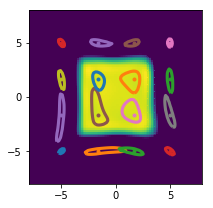

In [10]:
grid_points = get_grid(np.linspace(-5,5,4), idx_i,idx_j,np.zeros(p.D))
grid_data_one=np.linspace(-8,8,100)
grid_data   = get_grid(grid_data_one, idx_i,idx_j,np.zeros(p.D))

plt.figure(figsize=(3,3))
kernel_vals = []
for ki in range(len(dl_model.ops["kernel_grams"])):
    
    kvs = dl_model.sess.run(dl_model.ops["kernel_grams"][ki], feed_dict={dl_model.test_points: grid_points, dl_model.test_data: grid_data})
    kernel_vals.append(kvs)
    for i in range(kvs.shape[0]):
        kv = kvs[i]
        plt.contour(grid_data_one, grid_data_one, kv.reshape(100,100), [0.9], vmin=kv.min(), vmax=kv.max(), colors="C%d"%(i%9), linewidths=[(0.1*(ki+1)**2+3)])
        plt.plot(grid_points[i,idx_i], grid_points[i,idx_j], ".",  color="C%d"%(i%9))
pcolor = plt.pcolor(grid_data_one, grid_data_one, logpdf.reshape(ngrid, ngrid), vmin=-15)
pcolor.set_edgecolor('face')
plt.xlim(grid_data_one.min(),grid_data_one.max())
plt.ylim(grid_data_one.min(),grid_data_one.max())
plt.gca().set_yticks([-5,0,5])
plt.gca().set_aspect("equal", "box")
plt.tight_layout()
#plt.colorbar()
#plt.savefig("figs/%s.pdf"%p.name)

# Sampling

In [19]:
nsample = 200
Madapt = 100
delta = 0.7
thin = 5
nchain = 1

def lnprobfn(x):
    x = np.atleast_2d(x)
    return dl_model.fun_multiple(x, batch_size=1)[0]


def gradfn(x):
    x = np.atleast_2d(x)
    return dl_model.grad_multiple(x, batch_size=1)[0]

def lnprobgradfun(x):
    x = np.atleast_2d(x)
    return dl_model.fun_multiple(x, batch_size=1)[0], dl_model.grad_multiple(x, batch_size=1)[0]

samples = []
for i in range(nchain):
    #sampler = NUTSSampler(D, lnprobfn, gradfn)
    #s = sampler.run_mcmc(np.zeros(p.D), nsample*thin/nchain, Madapt, delta)
    s, lnprob, epsilon = nuts.nuts6(lnprobgradfun, nsample*thin/nchain, Madapt, np.zeros(p.D), delta)
    samples.append(s[::thin])
samples = np.concatenate(samples, axis=0)

nuts sampling:   1%|▍                                              | 9/1099 [00:00<00:17, 60.78it/s]

('find_reasonable_epsilon=', 2.0)


nuts sampling:  22%|██████████                                   | 246/1099 [00:03<00:11, 76.13it/s]Exception KeyError: KeyError(<weakref at 0x7f7e11a08100; to 'tqdm' at 0x7f7e12745150>,) in <object repr() failed> ignored


KeyboardInterrupt: 

# Train maf and sample from it

In [11]:
n_hiddens = 100
n_layers = 5
n_comps = 10

act_fun = 'tanh'
mode = 'random'

#p = load_data("ring",D=2, data_args={"nring":1, "sigma":0.2}, N=5000, valid_thresh=0.0, noise_std = noise_std, seed=seed, itanh=False, whiten=True)

if p.name == "Ring":
    maf_data_obj = ex.load_data("ring", D=p.D, data_args={"nring":1, "sigma":0.2}, 
                                noise_std=0, seed=seed, itanh=False, whiten=False, N=5000)
elif p.name == "Spiral":
    maf_data_obj = ex.load_data("spiral", D=p.D, data_args={"sigma":0.2, "eps":1.5}, 
                                noise_std=0, seed=seed, itanh=False, whiten=False, N=5000)
elif p.name == "Funnel":
    maf_data_obj = ex.load_data("funnel",D=2,  N=5000, seed=seed, itanh=False, whiten=True)
    
elif p.name == "Cosine":
    maf_data_obj = ex.load_data("cosine",D=2,  N=5000, seed=seed, itanh=False, whiten=True)
elif p.name == "array":
    data = np.random.rand(5000,2) * 6-3
    maf_data_obj = ex.load_data("array", data_array=data, whiten=False, itanh=False)

grid_data_one=np.linspace(-8,8,100)
grid_data   = get_grid(grid_data_one, idx_i,idx_j,np.zeros(p.D))

mog_made_model = ex.train_mog_made([n_hiddens]*2, act_fun, n_comps, mode)
ex.save_model(mog_made_model, "mog_made", mode, [n_hiddens]*2, act_fun, n_comps, False)
mog_made_model = ex.load_model("mog_made", mode, [n_hiddens]*2, act_fun, n_comps, False)
mog_made_pdf = mog_made_model.eval(grid_data)
mog_made_loglik = mog_made_model.eval(p.test_data).mean()
print "mog_made %.5f" % mog_made_loglik

made_model = ex.train_made([n_hiddens]*2, act_fun, mode)
ex.save_model(made_model, "made", mode, [n_hiddens]*2, act_fun, n_comps, False)
made_model = ex.load_model("made", mode, [n_hiddens]*2, act_fun, n_comps, False)
made_pdf = made_model.eval(grid_data)
made_loglik = made_model.eval(p.test_data).mean()
print "made %.5f" % made_loglik


nvp_model =ex.train_realnvp([n_hiddens]*2, 'tanh', 'relu', n_layers)
ex.save_model(nvp_model, "nvp", mode, [n_hiddens]*2, act_fun, n_comps, False)
nvp_model = ex.load_model("nvp", mode, [n_hiddens]*2, act_fun, n_comps, False)
nvp_pdf = nvp_model.eval(grid_data)
nvp_loglik = nvp_model.eval(p.test_data).mean()
print "nvp %.5f" % nvp_loglik


maf_model = ex.train_maf([n_hiddens]*2, act_fun, n_layers, mode)
ex.save_model(maf_model, "maf", mode, [n_hiddens]*2, act_fun, n_comps, False)
maf_model = ex.load_model("maf", mode, [n_hiddens]*2, act_fun, n_comps, False)
maf_pdf = maf_model.eval(grid_data)
maf_loglik = maf_model.eval(p.test_data).mean()
print "maf %.5f" % maf_loglik

mog_maf_model = ex.train_maf_on_made([n_hiddens]*2, act_fun, n_layers, n_comps, mode)
ex.save_model(mog_maf_model, "mog_maf", mode, [n_hiddens]*2, act_fun, n_comps, False)
mog_maf_model = ex.load_model("mog_maf", mode, [n_hiddens]*2, act_fun, n_comps, False)
mog_maf_pdf = mog_maf_model.eval(grid_data)
mog_maf_loglik = mog_maf_model.eval(p.otest_data).mean()
print "mog_maf %.5f" % mog_maf_loglik

mog_made -3.66912
made -3.95641
nvp -3.68328


maf/ml/models/mafs.py:56: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  input_order = input_order if input_order == 'random' else made.input_order[::-1]


maf -3.69138
mog_maf -3.65847


In [12]:
np.savez("figs/%s_data"%p.name, 
         kernel_vals=kernel_vals, logpdf=logpdf, grid_points=grid_points, dl_model_loglik=dl_model_loglik,
        made_pdf=made_pdf, made_mog_pdf=mog_made_pdf, nvp_pdf=nvp_pdf, maf_pdf=maf_pdf, maf_mog_pdf=mog_maf_pdf,
        made_loglik=made_loglik, made_mog_loglik=mog_made_loglik, nvp_loglik=nvp_loglik, maf_loglik=maf_loglik, maf_mog_loglik=mog_maf_loglik,)

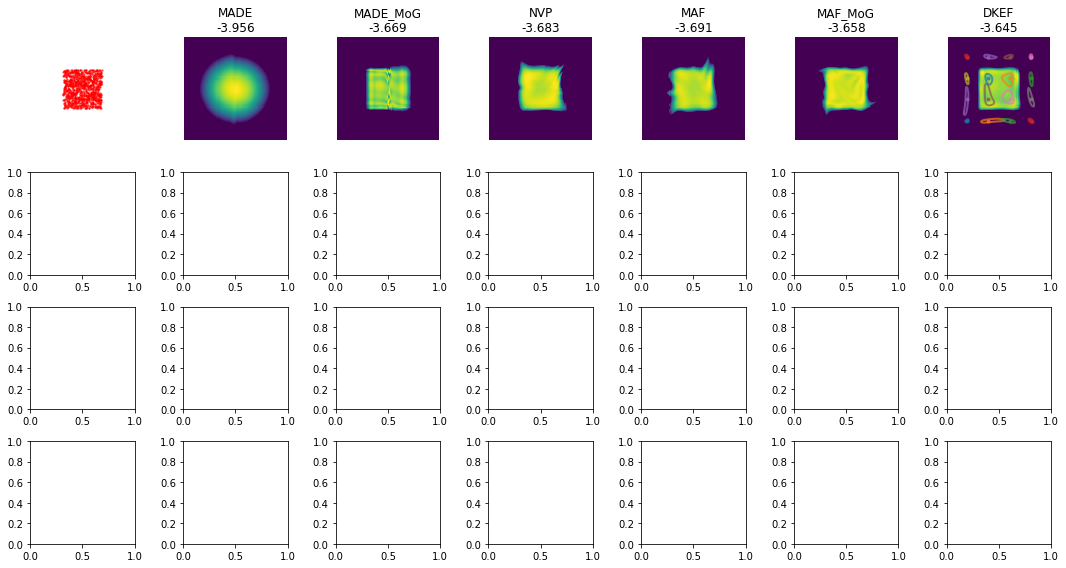

In [14]:
fig, axes = plt.subplots(4,7, figsize=(15,8))

others_list =["MADE", "MADE_MoG", "NVP", "MAF", "MAF_MoG"]


idx_i, idx_j=0,1
grid_points = get_grid(np.linspace(-5,5,4), idx_i,idx_j,np.zeros(p.D))
grid_data_one=np.linspace(-8,8,100)
grid_data   = get_grid(grid_data_one, idx_i,idx_j,np.zeros(p.D))


def plot_logpdf(ax, pdf):
    pdf -= pdf.max()
    pcolor = ax.pcolor(grid_data_one, grid_data_one, pdf.reshape(ngrid, ngrid), vmin=-5)
    pcolor.set_edgecolor('face')
    ax.set_xlim(grid_data_one.min(),grid_data_one.max())
    ax.set_ylim(grid_data_one.min(),grid_data_one.max())
    ax.set_yticks([-5,0,5])
    ax.set_aspect("equal", "box")
    ax.set_axis_off()


    
#for di, dname in enumerate(["Funnel","Ring","Spiral", "Cosine"]):
for di, dname in enumerate(["Array"]):

    
    ax = axes[di, 0]
    if dname == "Ring":
        this_p = load_data(dname, D=2, data_args={"nring":1, "sigma":0.2}, seed=seed)
    elif dname == "Spiral":
        this_p = load_data("spiral",D=2,  N=5000, data_args={"sigma":0.2, "eps":1.5}, valid_thresh=0.0, seed=seed, itanh=False, whiten=True)
    elif dname == "Funnel":
        this_p = load_data("funnel",D=2,  N=5000, valid_thresh=0.0, seed=seed, itanh=False, whiten=True)
    elif dname == "Cosine":
        this_p = load_data("Cosine",D=2,  N=5000, valid_thresh=0.0, seed=seed, itanh=False, whiten=True)
    elif dname == "Array":
        this_p = p


    if this_p.dist.has_grad:
        
        real_pdf = this_p.logpdf_multiple(grid_data)
        plot_logpdf(ax, real_pdf)
        real_loglik = this_p.logpdf_multiple(this_p.test_data).mean()
        if di == 0:
            ax.set_title("true model\n%.3f" % real_loglik)
        else:
            ax.set_title("%.3f" % real_loglik)
        #ax.scatter(p.test_data[:,0], p.test_data[:,1], 2,"r", alpha=0.1)
    else:
        s = this_p.sample(1000)
        ax.scatter(s[:,0], s[:,1],2,"r", alpha=0.5)
        ax.set_xlim(grid_data_one.min(),grid_data_one.max())
        ax.set_ylim(grid_data_one.min(),grid_data_one.max())
        ax.set_yticks([-5,0,5])
        ax.set_aspect("equal", "box")
        ax.set_axis_off()
        
    saved_pdf = np.load("figs/%s_data.npz" % this_p.name)
    for mi, mname in enumerate(others_list):
        ax = axes[di, mi+1]
        pdf = saved_pdf[mname.lower()+"_pdf"]
        plot_logpdf(ax, pdf)
        loglik = saved_pdf[mname.lower()+"_loglik"]
        if di == 0:
            ax.set_title("%s\n%.3f"%(mname, loglik))
        else:
            ax.set_title("%.3f"%loglik)
        

        
    ax = axes[di, -1]
    
    kernel_vals = saved_pdf["kernel_vals"]
    grid_points = saved_pdf["grid_points"]
    kvs = kernel_vals[0] 
    for i in range(kvs.shape[0]):
        kv = kvs[i]
        ax.contour(grid_data_one, grid_data_one, kv.reshape(100,100), [0.9], vmin=kv.min(), vmax=kv.max(), colors="C%d"%(i%9), linewidths=[2], alpha=.7)
        ax.plot(grid_points[i,idx_i], grid_points[i,idx_j], ".",  color="C%d"%(i%9), alpha=0.7)
    pdf = saved_pdf["logpdf"]
    plot_logpdf(ax, pdf)
    dl_model_loglik = saved_pdf["dl_model_loglik"]
    if di == 0:
        ax.set_title("DKEF\n%.3f"%dl_model_loglik)
    else:
        ax.set_title("%.3f"%dl_model_loglik)

plt.tight_layout()
#plt.colorbar()
#plt.savefig("figs/%s.pdf"%p.name)

# Maf density 

(-8.0, 8.0)

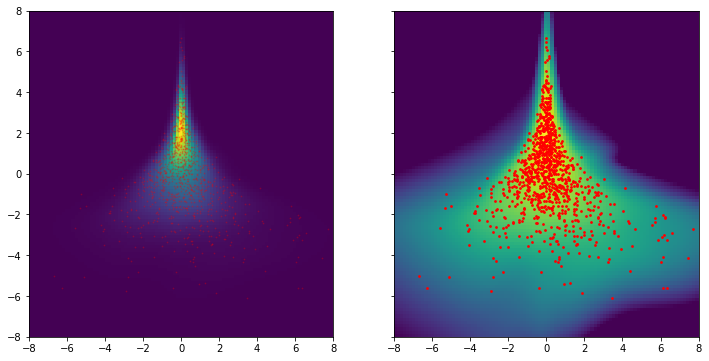

In [91]:
fv = maf_model.eval(eval_points)

fig, axes = plt.subplots(1,2, figsize=(12,6), sharex=True, sharey=True)

ax = axes[0]

logpdf = fv.copy() - fv.max()
pdf = np.exp(logpdf - logpdf.max())
pdf /= pdf.sum()
ax.pcolor(eval_grid, eval_grid, pdf.reshape(ngrid, ngrid))
ax.scatter(p.data[:1000,idx_i], p.data[:1000,idx_j], 1, color="r", alpha=0.2)


ax = axes[1]
ax.pcolor(eval_grid, eval_grid, logpdf.reshape(ngrid, ngrid), vmin=-10)
ax.scatter(p.data[:1000,idx_i], p.data[:1000,idx_j], 3, color="r", alpha=1.0)

dim = range(p.D)
dim.remove(idx_i)
dim.remove(idx_j)
idx_in_range = np.all( (p.test_data[:,dim]<cond_values[dim]+epsilon) &  (p.test_data[:,dim]>cond_values[dim]-epsilon), axis=1)
data_in_range = p.test_data[idx_in_range]
#plt.scatter(data_in_range[:,i], data_in_range[:,j], 15, color="b")

ax.set_xlim(eval_grid.min(),eval_grid.max())
ax.set_ylim(eval_grid.min(),eval_grid.max())

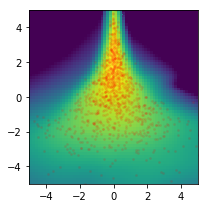

In [92]:
eval_grid = np.linspace(-8,8,ngrid)

grid_points = get_grid(np.linspace(-5,5,4), idx_i,idx_j,np.zeros(p.D))
grid_data_one=np.linspace(-5,5,100)
grid_data   = get_grid(grid_data_one, idx_i,idx_j,np.zeros(p.D))

plt.figure(figsize=(3,3))

pcolor = plt.pcolor(eval_grid, eval_grid, logpdf.reshape(ngrid, ngrid), vmin=-10)
pcolor.set_edgecolor('face')
plt.scatter(p.test_data[:,idx_i], p.test_data[:,idx_j], 3, "r", alpha=0.1)
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.tight_layout()

plt.savefig("figs/%s_mog_maf.pdf"%p.name)


# transform maf samples from Gaussian -> generated_data or true_data -> latent 

In [74]:
def plot_samples(x, idx_i, idx_j):
    rn = maf_model.calc_random_numbers(x)
    c = np.arctan2(x[:,0],x[:,1])
    c = c+1.1
    c[c>np.pi]-= 2*np.pi
    c = "r"
    fig, axes = plt.subplots(1,2,figsize=(6,3))

    ax = axes[0]
    ax.scatter(x[:,idx_i], x[:,idx_j], 3, c)
    ax.set_title("data")
    ax = axes[1]
    ax.scatter(rn[:,idx_i], rn[:,idx_j], 3, c)
    ax.set_title("latent")

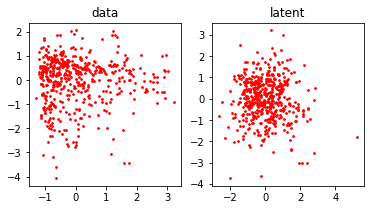

In [75]:
plot_samples(p.test_data, idx_i, idx_j)

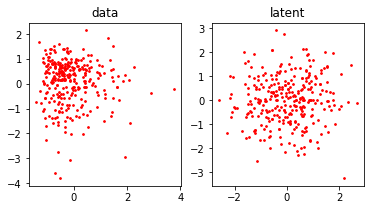

In [77]:
plot_samples(maf_model.gen(300), idx_i, idx_j)